# **Importing required files**

In [ ]:
import pandas as pd
import numpy as np
import os
import PIL
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.io import read_image
from scipy import stats
from scipy.stats.stats import pearsonr

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
csv_file = '/content/gdrive/MyDrive/2019SkyDataAll/2019_7200_train_01.csv'
df = pd.read_csv(csv_file) 
df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,date,time,short_ex,long_ex,global_solar_flux,solar_zenith_angle,solar_azimuthal_angle,category
0,0,7212,54118,10/24/2019,12:42:00 PM,20191024124200_01.jpg,20191024124200_03.jpg,123.75,62,18.631,1
1,1,1469,11147,3/14/2019,8:28:00 AM,20190314082800_01.jpg,20190314082800_03.jpg,68.54,69,-58.879,1
2,2,2876,21855,5/9/2019,2:38:00 PM,20190509143800_01.jpg,20190509143800_03.jpg,250.09,47,63.012,1
3,3,6170,46380,9/17/2019,12:16:00 PM,20190917121600_01.jpg,20190917121600_03.jpg,860.11,47,10.554,1
4,4,2829,21477,5/8/2019,9:12:00 AM,20190508091200_01.jpg,20190508091200_03.jpg,35.94,45,-58.549,1
...,...,...,...,...,...,...,...,...,...,...,...
7195,7195,5104,38539,8/4/2019,1:22:00 PM,20190804132200_01.jpg,20190804132200_03.jpg,583.00,36,36.247,1
7196,7196,6510,48852,10/1/2019,8:26:00 AM,20191001082600_01.jpg,20191001082600_03.jpg,53.53,67,-54.616,1
7197,7197,4349,32784,6/23/2019,2:40:00 PM,20190623144000_01.jpg,20190623144000_03.jpg,617.05,41,67.617,1
7198,7198,4502,34041,7/11/2019,12:04:00 PM,20190711120400_01.jpg,20190711120400_03.jpg,1098.86,27,4.051,1


In [ ]:
!unzip /content/gdrive/MyDrive/2019SkyDataAll/2019_24k.zip > /dev/null

In [ ]:
!unzip /content/gdrive/MyDrive/2019SkyDataAll/2019_01_8k.zip > /dev/null

In [ ]:
!unzip /content/gdrive/MyDrive/2019SkyDataAll/2019_02_8k.zip > /dev/null

In [ ]:
!unzip /content/gdrive/MyDrive/2019SkyDataAll/2019_03_8k.zip > /dev/null

# **Defining required classes**

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
      
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 5])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 7]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)
      
        return image, label

In [ ]:
class SolarResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=False, progress=True)
        self.model.conv1 = nn.Conv2d(1,64, kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
        self.model.fc = nn.Linear(in_features = 512, out_features = 1, bias=True)

    def forward(self, x):
        x = self.model(x)
        
        return x

In [ ]:
model = SolarResNet18()
model

# **Full data set training**

**Training set**

In [ ]:
train_csv_file = '/content/gdrive/MyDrive/2019SkyDataAll/2019_21600_train.csv'     
image_folder = '/content/2019_24k'

train_set = CustomImageDataset(train_csv_file , image_folder, transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),  
]))

train_data_len = len(train_set)

train_size = 21600  
batch_size = 100
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

l = len(train_loader)

**Validation set**

In [ ]:
validation_csv_set ='/content/gdrive/MyDrive/2019SkyDataAll/2019_400_evel_03.csv'    
image_folder = '/content/2019_03_8k'

validation_set = CustomImageDataset(validation_csv_set , image_folder, transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),  
]))

validation_data_len = len(validation_set)


#validation_size = 1200
batch_size = 400
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True)

l = len(validation_loader)

**Test set**

In [ ]:
test_csv_file = '/content/gdrive/MyDrive/2019SkyDataAll/2019_400_test_03.csv'        
image_folder = '/content/2019_03_8k'

test_set = CustomImageDataset(test_csv_file , image_folder, transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),  
]))

test_data_len = len(test_set)

#test_size = 1200   
batch_size = 400
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

l = len(test_loader)

# **Display images**

Feature batch shape: torch.Size([400, 1, 64, 64])
Labels batch shape: torch.Size([400])
torch.Size([64, 64])
Label: 135.68


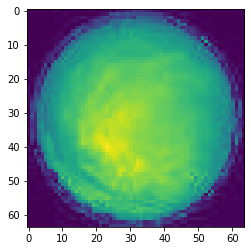

In [ ]:
train_features, train_labels = next(iter(test_loader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
print(img.shape)
label = train_labels[0]
print(f"Label: {label}")
img = transforms.ToPILImage()(img)
plt.imshow(img)
plt.show()

# **Save and Load the models**

**Save the model**

In [ ]:
model_load_name = 'SolarResNet18_24k_FINAL_RMSE.pth'  #'SolarResNet18_24k_FINAL.pth'
load_path = F"/content/gdrive/MyDrive/2019_Sky_Models/{model_load_name}"

model_save_name = 'SolarResNet18_24k_FINAL_RMSE.pth'
save_path = F"/content/gdrive/MyDrive/2019_Sky_Models/{model_save_name}"

loss_arr_save_path = "/content/gdrive/MyDrive/2019_Sky_Models/"


array_rain_fall = [1]

def save_checkpoint(state, filename = save_path):
  print("=> saving checkpoint")
  torch.save(state,filename)

def load_checkpoint(checkpoint):
  print("=> loading checkpoint")
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def save_loss_array(array):
  np.savetxt(fname=loss_arr_save_path +"loss_array_SolarResNet18_24k_FINAL_RMSE.csv", delimiter=",", X=array)

def load_loss_array(loss_cat):
  arr = []
  if os.path.isfile("/content/gdrive/MyDrive/2019_Sky_Models/loss_array_SolarResNet18_24k_FINAL_RMSE.csv"):
      if loss_cat == "total_loss":
        return np.loadtxt(
          fname="/content/gdrive/MyDrive/2019_Sky_Models/loss_array_SolarResNet18_24k_FINAL_RMSE.csv", delimiter=","
      )
  else:
    return arr

def save_loss_arrayv(array):
  np.savetxt(fname=loss_arr_save_path +"loss_array_SolarResNet18_24k_FINAL_VAL_RMSE.csv", delimiter=",", X=array)

def load_loss_arrayv(loss_cat):
  arr = []
  if os.path.isfile("/content/gdrive/MyDrive/2019_Sky_Models/loss_array_SolarResNet18_24k_FINAL_VAL_RMSE.csv"):
      if loss_cat == "total_loss":
        return np.loadtxt(
          fname="/content/gdrive/MyDrive/2019_Sky_Models/loss_array_SolarResNet18_24k_FINAL_VAL_RMSE.csv", delimiter=","
      )
  else:
    return arr

**Load the model**

In [ ]:
def MSE(yhat,y):
    return torch.mean((yhat-y)**2)

In [ ]:
def RMSE(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [ ]:
load_model = True
model = SolarResNet18()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
MSE = nn.MSELoss()

In [ ]:
if load_model and os.path.isfile(load_path):
  load_checkpoint(torch.load(load_path))

=> loading checkpoint


# **Train and Eval**

In [ ]:
#best_loss = 500

best_loss = np.amin(load_loss_arrayv("total_loss"))
best_loss

47.65170694614461

In [ ]:
epochs = 22

for epoch in range(epochs):

  model.train()
  running_loss = 0
  batch_no = 0

  for batch in train_loader: # Get batch
    images, labels = batch

    preds = model(images) # Pass batch

    Y = torch.tensor(labels)
    new_shape = (len(labels), 1)
    Y = Y.view(new_shape)

    loss = RMSE(preds,Y) # Calculate loss

    optimizer.zero_grad()
    loss.backward() # Calculate gradients
    optimizer.step() # Update weights

    print(f"Epoch: {epoch}   ",f"Batch: {batch_no}   ",f"Loss: {loss.item()}")

    batch_no += 1
    running_loss += loss.item()

  epoch_loss = running_loss/len(train_loader)
  
  loss_array = load_loss_array("total_loss")
  loss_array = np.append(loss_array, epoch_loss)
  save_loss_array(np.array(loss_array))
  
  print(f"Loss after Epoch: {epoch}  => ",f"Loss: {epoch_loss}")
  print(loss_array)

  model.eval()
  for vbatch in validation_loader: # Get batch
    vimage, vlabel = vbatch

    vpreds = model(vimage) # Pass batch

    vY = torch.tensor(vlabel)
    vnew_shape = (len(vlabel), 1)
    vY = vY.view(vnew_shape)

    vloss = RMSE(vpreds,vY) # Calculate loss
    print(f"Validation Loss after Epoch: {epoch}  => ",f"Val Loss: {vloss.item()}")
  
  loss_array2 = load_loss_arrayv("total_loss")
  loss_array2 = np.append(loss_array2, vloss.item())
  save_loss_arrayv(np.array(loss_array2))

  print(loss_array2)

  if vloss < best_loss:
    checkpoint = {'model_state_dict' : model.state_dict(), 'optimizer_state_dict' : optimizer.state_dict()}
    save_checkpoint(checkpoint)
    best_loss = vloss


Streaming output truncated to the last 5000 lines.
Epoch: 1    Batch: 189    Loss: 59.88595744466903
Epoch: 1    Batch: 190    Loss: 43.51455243788789
Epoch: 1    Batch: 191    Loss: 51.98668685822128
Epoch: 1    Batch: 192    Loss: 41.776783522748296
Epoch: 1    Batch: 193    Loss: 50.64014392547469
Epoch: 1    Batch: 194    Loss: 49.52721108012014
Epoch: 1    Batch: 195    Loss: 44.12818443182458
Epoch: 1    Batch: 196    Loss: 49.97651587117366
Epoch: 1    Batch: 197    Loss: 48.31137527627823
Epoch: 1    Batch: 198    Loss: 46.93190120530797
Epoch: 1    Batch: 199    Loss: 60.0548877556818
Epoch: 1    Batch: 200    Loss: 52.045793219364526
Epoch: 1    Batch: 201    Loss: 73.08867652194935
Epoch: 1    Batch: 202    Loss: 59.485366233928985
Epoch: 1    Batch: 203    Loss: 48.932406567454926
Epoch: 1    Batch: 204    Loss: 48.91466202926897
Epoch: 1    Batch: 205    Loss: 45.45052246126113
Epoch: 1    Batch: 206    Loss: 45.746233568566495
Epoch: 1    Batch: 207    Loss: 47.0652267438

 **Test & Val the model**

---



In [ ]:
def RMSE(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

def nRMSE(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))/(torch.mean(yhat))

MAE = nn.L1Loss()

def Pearson(yhat,y):
  yhatm = torch.mean(yhat)
  ym = torch.mean(y)

  N = torch.sum((y-ym)*(yhat-yhatm))
  D = torch.sqrt((torch.sum((y-ym)**2))*(torch.sum((yhat-yhatm)**2)))

  return N/D

In [ ]:
model = SolarResNet18()
load_checkpoint(torch.load(load_path))

model.eval()

for batch in test_loader: # Get batch
    image, label = batch

    preds = model(image) # Pass batch

    Y = torch.tensor(label)
    new_shape = (len(label), 1)
    Y = Y.view(new_shape)

    MAEloss = MAE(preds,Y) # Calculate loss
    RMSEloss = RMSE(preds,Y)
    nRMSEloss = nRMSE(preds,Y)
    PearsonC = Pearson(preds,Y) 

    print(f"Test MAE: {MAEloss}")
    print(f"Test RMSE: {RMSEloss}")
    print(f"Test nRMSE: {nRMSEloss}")
    print(f"Test Pearson: {PearsonC}")


for batch in validation_loader: # Get batch
    image, label = batch

    preds = model(image) # Pass batch

    Y = torch.tensor(label)
    new_shape = (len(label), 1)
    Y = Y.view(new_shape)

    MAEloss = MAE(preds,Y) # Calculate loss
    RMSEloss = RMSE(preds,Y)
    nRMSEloss = nRMSE(preds,Y)
    PearsonC = Pearson(preds,Y) 

    print("-----------------------------------------------")
    
    print(f"Validation MAE: {MAEloss}")
    print(f"Validation RMSE: {RMSEloss}")
    print(f"Validation nRMSE: {nRMSEloss}")
    print(f"Validation Pearson: {PearsonC}")

=> loading checkpoint
Test MAE: 34.16424560546875
Test RMSE: 56.84991001739249
Test nRMSE: 0.14826776538969835
Test Pearson: 0.9798913125034506
-----------------------------------------------
Validation MAE: 34.27702331542969
Validation RMSE: 53.341541874574
Validation nRMSE: 0.14218105122207686
Validation Pearson: 0.9799432501342975


**Individual Inspection**

In [ ]:
model = SolarResNet18()
load_checkpoint(torch.load(load_path))

model.eval()
MAE = nn.L1Loss()

for batch in test_loader: # Get batch
    image, label = batch

    pred = model(image) # Pass batch

    Y = torch.tensor(label)
    new_shape = (len(label), 1)
    Y = Y.view(new_shape)

    loss = MAE(pred,Y) # Calculate loss

    print(f"Label: {label.item()}     ",f"Pred: {pred.item()}     ", f"Loss : {loss.item()}     ",f"Percentage Loss : {loss.item()/label.item()*100} %     " )



=> loading checkpoint
Label: 135.68      Pred: 192.09518432617188      Loss : 56.415184020996094      Percentage Loss : 41.579587279625656 %     
Label: 63.29      Pred: 55.057159423828125      Loss : 8.232840538024902      Percentage Loss : 13.00812219627888 %     
Label: 524.04      Pred: 544.7222290039062      Loss : 20.682228088378906      Percentage Loss : 3.9466888192464142 %     
Label: 722.01      Pred: 699.4024047851562      Loss : 22.607595443725586      Percentage Loss : 3.1312025378769808 %     
Label: 314.25      Pred: 443.8932189941406      Loss : 129.64321899414062      Percentage Loss : 41.254803180315236 %     
Label: 511.02      Pred: 467.5721435546875      Loss : 43.44785690307617      Percentage Loss : 8.502183261531089 %     
Label: 1014.45      Pred: 974.474609375      Loss : 39.97539138793945      Percentage Loss : 3.9405975048488786 %     
Label: 140.4      Pred: 208.9037322998047      Loss : 68.50373077392578      Percentage Loss : 48.791831035559674 %     
Lab